# 1. Download dataset

In [ ]:
# Download ICDAR 2003 dataset
# !gdown 1kUy2tuH-kKBlFCNA0a9sqD2TG4uyvBnV
!unzip -q icdar2003.zip -d datasets

# 2. Install required libraries

In [ ]:
!pip install -q ultralytics --upgrade

In [ ]:
import os
import json
import yaml
from ultralytics import YOLO
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from modules.dataset_processor import OCRDatasetProcessor

In [ ]:
processor = OCRDatasetProcessor(blank_char='-')

In [ ]:
dataset_dir = "datasets/SceneTrialTrain"
words_xml_path = os.path.join(dataset_dir, "words.xml")
image_paths, image_sizes, image_labels, bounding_boxes = processor.extract_data_from_xml(
    words_xml_path
)

print(f"Number of images: {len(image_paths)}")
print(f"Example image path: {image_paths[0]}")
print(f"Example image size: {image_sizes[0]}")
print(f"Example bounding boxes: {bounding_boxes[0][:2]}")
print(f"Example labels: {image_labels[0][:2]}")

Number of images: 250
Example image path: apanar_06.08.2002/IMG_1261.JPG
Example image size: (1600, 1200)
Example bounding boxes: [[174.0, 392.0, 274.0, 195.0], [512.0, 391.0, 679.0, 183.0]]
Example labels: ['self', 'adhesive']


# 4. Convert to YOLO format

In [ ]:
# Define class labels
class_labels = ["text"]

# Convert data into YOLO format
yolo_data = processor.convert_to_yolo_format(image_paths, image_sizes, bounding_boxes)

# 5. Train, val, test split

In [9]:
seed = 0
val_size = 0.2
test_size = 0.125
is_shuffle = True
train_data, test_data = train_test_split(
    yolo_data,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle,
)
test_data, val_data = train_test_split(
    test_data,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle,
)

# 6. Save data

In [ ]:
save_yolo_data_dir = "datasets/yolo_data"
os.makedirs(save_yolo_data_dir, exist_ok=True)
save_train_dir = os.path.join(save_yolo_data_dir, "train")
save_val_dir = os.path.join(save_yolo_data_dir, "val")
save_test_dir = os.path.join(save_yolo_data_dir, "test")

processor.save_data(train_data, dataset_dir, save_train_dir)
processor.save_data(test_data, dataset_dir, save_val_dir)
processor.save_data(val_data, dataset_dir, save_test_dir)

# 7. Create yaml file

In [12]:
data_yaml = {
    "path": "./datasets/yolo_data",
    "train": "train/images",
    "test": "test/images",
    "val": "val/images",
    "nc": 1,
    "names": class_labels,
}

yolo_yaml_path = os.path.join(save_yolo_data_dir, "data.yml")
with open(yolo_yaml_path, "w") as f:
    yaml.dump(data_yaml, f, default_flow_style=False)

# 8. Training

In [ ]:
# Model will be saved in "OCR-Pipeline/runs/detect/train/weights"
# Load pretrained YOLOv11 model
model = YOLO('yolo11m.pt')

# Start training
results = model.train(
    data=yolo_yaml_path,
    epochs=100,
    imgsz=640,
    batch=8,
    device=0,
    patience=20,
    plots=True,

    # Optimizer
    optimizer='auto',
    cache=True,
    warmup_epochs=3,
)

# 9. Evaluation

In [ ]:
model_path = "runs/detect/train/weights/best.pt"
model = YOLO(model_path)

metrics = model.val()

Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2445.7±863.8 MB/s, size: 111.9 KB)


val: Scanning /content/datasets/yolo_data/val/labels.cache... 43 images, 2 backgrounds, 0 corrupt: 100%|██████████| 43/43 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.68it/s]


                   all         43        200      0.907       0.91      0.929      0.734
Speed: 6.7ms preprocess, 22.2ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs/detect/val


# 10. Inference

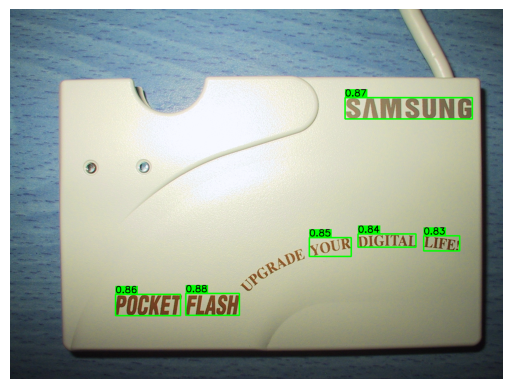

In [ ]:
model_path = "runs/detect/train/weights/best.pt"
img_path = "datasets/SceneTrialTrain/apanar_06.08.2002/IMG_1255.JPG"
conf_thres = 0.75
model = YOLO(model_path)

# Run inference
results = model(img_path, verbose=False)
predictions = json.loads(results[0].to_json())
visualized_img = processor.visualize_bbox(img_path, predictions, conf_thres)

%matplotlib inline
plt.imshow(visualized_img)
plt.axis("off")
plt.show()